In [1]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

**数据输入，分出变量X和标签Y**

In [2]:
dataset = loadtxt('dataset_001.csv', delimiter=",")

X = dataset[:,0:8]
Y = dataset[:,8]

**将数据集分为训练集和测试集，测试机用来预测，训练集用来学习**

In [11]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

直接使用xgboost封装好的分类器和回归器，可以直接使用XGBClassifier建立模型

http://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

In [17]:
# 不可视化数据集
#model = XGBClassifier()
#model.fit(X_train, y_train)

##可视化测试集的loss
model = XGBClassifier()
eval_set = [(X_test, y_test)]
model.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

xgboost的结果是每一个样本属于第一类的概率，要使用round将其转换为0 1值

In [20]:
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

In [21]:
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.56%


## 对每个特征的重要性进行分析

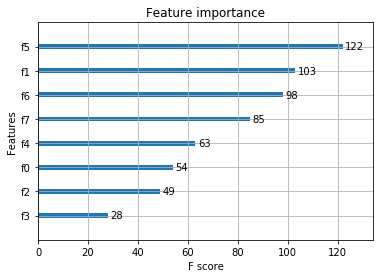

In [23]:
from xgboost import plot_importance
from matplotlib import pyplot


model.fit(X, Y)

plot_importance(model)
pyplot.show()

## 调参

如何调参呢，下面是三个超参数的一般实践最佳值，可以先将它们设定为这个范围，然后画出 learning curves，再调解参数找到最佳模型：

learning_rate ＝ 0.1 或更小，越小就需要多加入弱学习器；
tree_depth ＝ 2～8；
subsample ＝ 训练集的 30%～80%；

接下来我们用 GridSearchCV 来进行调参会更方便一些：
可以调的超参数组合有：  
树的个数和大小 (n_estimators and max_depth).  
学习率和树的个数 (learning_rate and n_estimators).  
行列的 subsampling rates (subsample, colsample_bytree and colsample_bylevel).  
下面以学习率为例

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

设定要调节的 learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
和原代码相比就是在 model 后面加上 grid search 这几行：

In [26]:
model = XGBClassifier()
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
param_grid = dict(learning_rate=learning_rate)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, Y)

In [27]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.483013 using {'learning_rate': 0.1}


打印出每个学习率对应的分数

In [28]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

-0.689650 (0.000242) with: {'learning_rate': 0.0001}
-0.661274 (0.001954) with: {'learning_rate': 0.001}
-0.530747 (0.022961) with: {'learning_rate': 0.01}
-0.483013 (0.060755) with: {'learning_rate': 0.1}
-0.515440 (0.068974) with: {'learning_rate': 0.2}
-0.557315 (0.081738) with: {'learning_rate': 0.3}
